In [1]:
from floris.floris import Floris
import matplotlib.pyplot as plt
import numpy as np
import scipy
import GPy
import random
import time
from visualization_manager import VisualizationManager
from pygmo import hypervolume

# Visualization
from copy import deepcopy
from pareto import Pareto
from scipy.optimize import minimize
from scipy.stats import norm
from pareto import Pareto
%matplotlib inline

In [2]:
def windFarmPower(floris,wd, ws, yawAngle,scale):
    
    #set up wind direction and speed
    floris.farm.flow_field.wind_direction = np.radians(wd - 270) # frame of reference is west
    floris.farm.flow_field.wind_speed = ws
    floris.farm.flow_field.initial_flowfield = floris.farm.flow_field._initial_flowfield()
    floris.farm.flow_field.u_field = floris.farm.flow_field._initial_flowfield()
    
    
    turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
    for k,turbine in enumerate(turbines):
        turbine.yaw_angle = np.radians(yawAngle[k])
    floris.farm.flow_field.calculate_wake()
    
    power = np.zeros([len(yawAngle),1])
    totalPower = 0.0
    for i, turbine in enumerate(turbines):
        power[i]=turbine.power
        totalPower = totalPower + turbine.power    
    
    return power/scale, totalPower/scale/len(turbines)

#run wind farm configuration input with a single wind turbine
floris = Floris("example_input_single.json")
numWT = 1
scale = 1.0
#conventional default input is yawAngle = 0 degree
yawAngle0 = np.zeros(numWT)

#compute the wind turbine power vector and total wind farm power (for single wind turbine they are the same)
powerSingle,totalPower = windFarmPower(floris,0, 8, yawAngle0,scale)

floris = Floris("example_input_double.json")
num_tur = len(floris.farm.flow_field.turbine_map.items())

In [3]:
def expected_improvement(Xcand, gp_model, current_min, wind_dir):
    Xcand = np.atleast_2d(Xcand)
    Xcand = np.hstack((Xcand, np.ones((len(Xcand), 1)) * wind_dir))
    mu, var = gp_model.predict(Xcand)
    sigma = np.sqrt(var)
    
    Z = (current_min - mu) / sigma
    ei = (current_min - mu) * norm.cdf(Z) + sigma * norm.pdf(Z)
    
    return -ei[0]

def single_next_point(acquisition, gp_model, bounds, eval_y, wind_dir, N_mc = 5000):

    best_x = None
    best_acquisition_value = 0
    n_params = bounds.shape[0]
    current_min = np.min(eval_y)
    # Random 한 점을 많이 찍고 그 중 가장 acquisition ftn value가 높은 지점을 start 지점으로 삼아 scipy minimize 함수 작동
    points = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(N_mc, n_params))
    evaluations = acquisition(points, gp_model, current_min, wind_dir)
    idx_best = np.argmin(evaluations, axis=0)
    
    result = minimize(fun=acquisition, x0 = points[idx_best, :], bounds=bounds, method='L-BFGS-B',args=(gp_model, current_min, wind_dir))

    if result.fun <= best_acquisition_value:
        best_acquisition_value = result.fun
        best_x = result.x

    return best_x

In [15]:
def hypervolume_poi(Xcand, gp_models, pareto, reference, outdim, wind_dir):
    Xcand = np.atleast_2d(Xcand)
    Xcand = np.hstack((Xcand, np.ones((len(Xcand), 1)) * wind_dir))
    num_cells = pareto.bounds.lb.shape[0]
    N = Xcand.shape[0]

    # Extended Pareto front
    pf_ext = np.concatenate([-np.inf * np.ones([1, outdim], dtype=float), pareto.front, reference], 0)

    # Predictions for candidates, concatenate columns
    preds = [m.predict(Xcand) for m in gp_models]
    candidate_mean, candidate_var = (np.concatenate(moment, 1) for moment in zip(*preds))
    candidate_var = np.maximum(candidate_var, 1e-6)  # avoid zeros

    # Calculate the cdf's for all candidates for every predictive distribution in the data points
    normal = scipy.stats.norm(candidate_mean, np.sqrt(candidate_var))
    Phi = np.transpose(normal.cdf(np.expand_dims(pf_ext, 1)), [1, 0, 2])  # N x pf_ext_size x outdim
    # tf.gather_nd indices for bound points
    col_idx = np.tile(range(outdim), (num_cells,))
    ub_idx = np.stack((np.reshape(pareto.bounds.ub, [-1]), col_idx), axis=1).astype(int)  # (num_cells*outdim x 2)
    lb_idx = np.stack((np.reshape(pareto.bounds.lb, [-1]), col_idx), axis=1).astype(int)  # (num_cells*outdim x 2)
    
    # Calculate PoI
    P1 = np.zeros((N, num_cells*outdim))
    P2 = np.zeros((N, num_cells*outdim))
    for i in range(len(ub_idx)):
        for k in range(N):
            P1[k,i] = np.transpose(Phi, [1, 2, 0])[ub_idx[i][0],ub_idx[i][1], k]  # N x num_cell*outdim
            P2[k,i] = np.transpose(Phi, [1, 2, 0])[lb_idx[i][0],lb_idx[i][1], k]  # N x num_cell*outdim
    P = np.reshape(P1 - P2, [N, num_cells, outdim])
    PoI = np.sum(np.prod(P, axis=2), axis=1, keepdims=True)  # N x 1

    # Calculate Hypervolume contribution of points Y
    ub_points = np.zeros((1, num_cells*outdim))
    lb_points = np.zeros((1, num_cells*outdim))
    for i in range(len(ub_idx)):
        ub_points[0,i] = pf_ext[ub_idx[i][0],ub_idx[i][1]]
        lb_points[0,i] = pf_ext[lb_idx[i][0],lb_idx[i][1]]
    ub_points = np.reshape(ub_points, [num_cells, outdim])
    lb_points = np.reshape(lb_points, [num_cells, outdim])

    splus_valid = np.all(np.tile(np.expand_dims(ub_points, 1), [1, N, 1]) > candidate_mean,
                                axis=2)  # num_cells x N
    splus_idx = np.expand_dims(splus_valid.astype(np.float64), -1)  # num_cells x N x 1
    splus_lb = np.tile(np.expand_dims(lb_points, 1), [1, N, 1])  # num_cells x N x outdim
    splus_lb = np.maximum(splus_lb, candidate_mean)  # num_cells x N x outdim
    splus_ub = np.tile(np.expand_dims(ub_points, 1), [1, N, 1])  # num_cells x N x outdim
    splus = np.concatenate([splus_idx, splus_ub - splus_lb], axis=2)  # num_cells x N x (outdim+1)
    Hv = np.transpose(np.sum(np.prod(splus, axis=2), axis=0, keepdims=True))  # N x 1
    
    # return HvPoI
    return -np.multiply(Hv, PoI)

def EHVI(Xcand, gp_models, pareto, reference, outdim, wind_dir):
    Xcand = np.atleast_2d(Xcand)
    Xcand = np.hstack((Xcand, np.ones((len(Xcand), 1)) * wind_dir))

    ext1, ext2 = np.array([[-np.inf, reference[0][1]]]), np.array([[reference[0][0], -np.inf]])
    pf_ext = np.concatenate([ext1, pareto.front, ext2], 0)

    # Predictions for candidates, concatenate columns
    preds = [m.predict(Xcand) for m in gp_models]
    candidate_mean, candidate_var = (np.concatenate(moment, 1) for moment in zip(*preds))
    candidate_var = np.maximum(candidate_var, 1e-6)  # avoid zeros

    normal1 = scipy.stats.norm(candidate_mean[:,0], np.sqrt(candidate_var[:,0]))
    normal2 = scipy.stats.norm(candidate_mean[:,1], np.sqrt(candidate_var[:,1]))
    
    P1 = np.zeros((Xcand.shape[0], len(pareto.front)+1))
    P2 = np.zeros((Xcand.shape[0], len(pareto.front)+1))
    
    for i in range(len(pareto.front)+1):
        if i == 0:
            P1[:,i] = 0
            P2[:,i] = (exipsi(pf_ext[i+1, 0], pf_ext[i+1, 0], normal1) - exipsi(pf_ext[i+1, 0], pf_ext[i, 0], normal1)) * exipsi(pf_ext[i, 1], pf_ext[i, 1], normal2)
        else:
            P1[:,i] = (pf_ext[i+1, 0] - pf_ext[i, 0]) * normal1.cdf(pf_ext[i, 0]) * exipsi(pf_ext[i, 1], pf_ext[i, 1], normal2) 
            P2[:,i] = (exipsi(pf_ext[i+1, 0], pf_ext[i+1, 0], normal1) - exipsi(pf_ext[i+1, 0], pf_ext[i, 0], normal1)) * exipsi(pf_ext[i, 1], pf_ext[i, 1], normal2)

            
    return -np.sum(P1 + P2, axis = 1)[:,None]

def exipsi(a, b, normal):
    return normal.std() * normal.pdf(b) + (a-normal.mean()) * normal.cdf(b)

def POI(Xcand, gp_models, pareto, reference, outdim, wind_dir):
    Xcand = np.atleast_2d(Xcand)
    Xcand = np.hstack((Xcand, np.ones((len(Xcand), 1)) * wind_dir))
    num_cells = pareto.bounds.lb.shape[0]
    N = Xcand.shape[0]

    # Extended Pareto front
    pf_ext = np.concatenate([-np.inf * np.ones([1, outdim], dtype=float), pareto.front, reference], 0)

    # Predictions for candidates, concatenate columns
    preds = [m.predict(Xcand) for m in gp_models]
    candidate_mean, candidate_var = (np.concatenate(moment, 1) for moment in zip(*preds))
    candidate_var = np.maximum(candidate_var, 1e-6)  # avoid zeros

    # Calculate the cdf's for all candidates for every predictive distribution in the data points
    normal = scipy.stats.norm(candidate_mean, np.sqrt(candidate_var))
    Phi = np.transpose(normal.cdf(np.expand_dims(pf_ext, 1)), [1, 0, 2])  # N x pf_ext_size x outdim
    # tf.gather_nd indices for bound points
    col_idx = np.tile(range(outdim), (num_cells,))
    ub_idx = np.stack((np.reshape(pareto.bounds.ub, [-1]), col_idx), axis=1).astype(int)  # (num_cells*outdim x 2)
    lb_idx = np.stack((np.reshape(pareto.bounds.lb, [-1]), col_idx), axis=1).astype(int)  # (num_cells*outdim x 2)
    
    # Calculate PoI
    P1 = np.zeros((N, num_cells*outdim))
    P2 = np.zeros((N, num_cells*outdim))
    for i in range(len(ub_idx)):
        for k in range(N):
            P1[k,i] = np.transpose(Phi, [1, 2, 0])[ub_idx[i][0],ub_idx[i][1], k]  # N x num_cell*outdim
            P2[k,i] = np.transpose(Phi, [1, 2, 0])[lb_idx[i][0],lb_idx[i][1], k]  # N x num_cell*outdim
    P = np.reshape(P1 - P2, [N, num_cells, outdim])
    PoI = np.sum(np.prod(P, axis=2), axis=1, keepdims=True)  # N x 1
    
    # return HvPoI
    return -PoI

def sample_next_point(acquisition, gp_model, bounds, pareto, reference, outdim, wind_dir, N_mc = 5000):
    """
    acquisition : acquisition function of Gaussian processes
    gp_model : gpflow Gaussian process model
    eval_y : evaluated y list in current state
    bounds : boundary of next point
    n_restarts : number of restarts for scipy.minimize
    
    return : next x    
    """
    best_x = None
    best_acquisition_value = 0
    n_params = bounds.shape[0]
    points = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(N_mc, n_params))
    evaluations = acquisition(points, gp_model, pareto, reference, outdim, wind_dir)
    idx_best = np.argmin(evaluations, axis=0)
    
    result = minimize(fun=acquisition, x0=points[idx_best, :], bounds=bounds, method='L-BFGS-B',args=(gp_model, pareto, reference, outdim, wind_dir))
    if result.fun <= best_acquisition_value:
        best_acquisition_value = result.fun
        best_x = result.x

    return best_x

In [5]:
def multiobj_f(yawangle):
    Y1 = np.zeros(len(yawangle))[:,None]
    Y2 = np.zeros(len(yawangle))[:,None]
    for i,angle in enumerate(yawangle):
        power,totalPower = windFarmPower(floris, angle[-1], 8, angle[:-1], powerSingle)
        Y1[i] = -totalPower
        Y2[i] = np.sum(np.square(np.radians(angle[:-1]))) / np.square(np.radians(25.0)) / num_tur
    Y = np.hstack((Y1,Y2))
    return Y

minimum_yaw_angle = 0.0
maximum_yaw_angle = 25.0

bounds = np.zeros((num_tur, 2))
for i in range(num_tur):
    bounds[i,:] = [minimum_yaw_angle, maximum_yaw_angle]
    
# number of turbines + wind context
n_params = bounds.shape[0]+1

In [6]:
current_wd = np.random.uniform(100,105)

all_x = []
opt_x = []
opt_y = []
for i in np.linspace(minimum_yaw_angle, maximum_yaw_angle, 150):
    temp_X1 = np.linspace(minimum_yaw_angle, maximum_yaw_angle, 150)[:, None]
    temp_X2 = (np.ones(len(temp_X1)) * i)[:, None]
    temp_X = np.hstack((temp_X1, temp_X2))
    
    all_x.extend(np.hstack((temp_X, np.ones((len(temp_X), 1))*current_wd)))
    
f_value = multiobj_f(np.array(all_x))
pareto = Pareto(np.empty((0,2)))
pareto.update(f_value)

idx = np.array([i for i in range(len(f_value)) if f_value[i,0] in pareto.front[:,0] and f_value[i,1] in pareto.front[:,1]])
opt_x.extend(np.array(all_x)[idx])
opt_y.extend(f_value[idx])
opt_x = np.array(opt_x)
opt_y = np.array(opt_y)

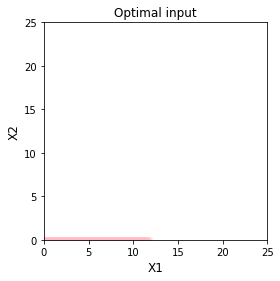

In [7]:
plt.figure(figsize=(4,4))
plt.xlim([0, 25])
plt.ylim([0, 25])

plt.title('Optimal input', fontsize = 12)
plt.xlabel('X1', fontsize = 12)
plt.ylabel('X2', fontsize = 12)

plt.scatter(opt_x[:,0], opt_x[:,1], color = 'lightpink', alpha = 0.4, zorder=1)
plt.show()

trial = 500

In [8]:
def average_error(output_list):
    err = []
    for i in range(len(output_list)):
        err.append(np.min(np.linalg.norm(opt_y - output_list[i], axis=1)))
        
    avg_err = np.zeros(len(err))
    for i in range(len(err)):
        avg_err[i] = np.sum(err[:i+1]) / (i+1)
    
    return avg_err

# Random strategy

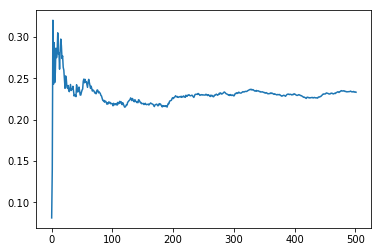

In [9]:
uniform = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(trial+2, bounds.shape[0]))
initial_input = np.hstack((uniform[:2], np.ones((2,1))*current_wd))
uniform_input = np.hstack((uniform[2:], np.ones((trial,1))*current_wd))
initial_output = multiobj_f(np.atleast_2d(initial_input))
uniform_output = multiobj_f(np.atleast_2d(uniform_input))

uniform_err = average_error(np.vstack((initial_output, uniform_output)))
plt.plot(uniform_err)
plt.show()

# linear scalization

In [10]:
def ls_f(yawangle):
    Y = np.zeros(len(yawangle))[:,None]
    for i,angle in enumerate(yawangle):
        power,totalPower = windFarmPower(floris, angle[-1], 8, angle[:-1], powerSingle)
        Y[i] = -totalPower/2 + np.sum(np.square(np.radians(angle[:-1]))) / np.square(np.radians(25.0)) / num_tur / 2
    return Y

 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 2 then the given X dimension 3. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/rbf.py:54: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide


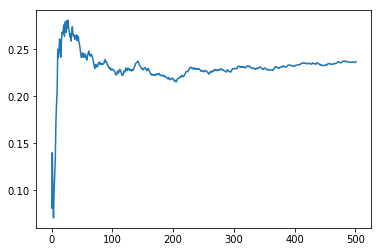

In [11]:
lin_input = np.atleast_2d(initial_input)
lin_output = ls_f(lin_input) 


for i in range(trial):
    gp_model = GPy.models.GPRegression(lin_input.copy(), lin_output.copy(), kernel= GPy.kern.RBF(input_dim=n_params-1, ARD=True))
    gp_model.optimize()
    
    next_point = np.atleast_2d(single_next_point(expected_improvement, gp_model, bounds, lin_output, current_wd))
    next_point = np.hstack((next_point, np.ones((1,1)) * current_wd))
    lin_input = np.append(lin_input, next_point, axis = 0)
    function_value = ls_f(np.atleast_2d(next_point))
    lin_output = np.append(lin_output, function_value, axis = 0)
    
lin_err = average_error(multiobj_f(lin_input))
plt.plot(lin_err)
plt.show()

# No - preference method

In [12]:
def nopre_f(yawangle):
    opt = np.array([[-1, 0]])
    Y = np.zeros(len(yawangle))[:,None]
    for i,angle in enumerate(yawangle):
        power,totalPower = windFarmPower(floris, angle[-1], 8, angle[:-1], powerSingle)
        f = np.array([[-totalPower, np.sum(np.square(np.radians(angle[:-1]))) / np.square(np.radians(25.0)) / num_tur]])
        Y[i] = np.linalg.norm(f)
    return Y

 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 2 then the given X dimension 3. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


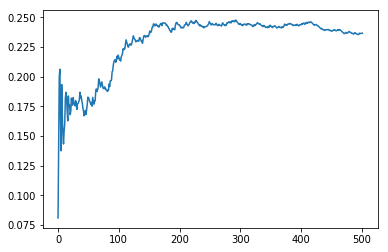

In [13]:
no_input = np.atleast_2d(initial_input)
no_output = nopre_f(no_input) 


for i in range(trial):
    gp_model = GPy.models.GPRegression(no_input.copy(), no_output.copy(), kernel= GPy.kern.RBF(input_dim=n_params-1, ARD=True))
    gp_model.optimize()
    
    next_point = np.atleast_2d(single_next_point(expected_improvement, gp_model, bounds, no_output, current_wd))
    next_point = np.hstack((next_point, np.ones((1,1)) * current_wd))
    no_input = np.append(no_input, next_point, axis = 0)
    function_value = nopre_f(np.atleast_2d(next_point))
    no_output = np.append(no_output, function_value, axis = 0)
    
no_err = average_error(multiobj_f(no_input))
plt.plot(no_err)
plt.show()

# Multi-objective Bayesian optimization

In [14]:
mbo_input = np.atleast_2d(initial_input)
mbo_output = multiobj_f(mbo_input) 

num_output = mbo_output.shape[1]

for i in range(trial):
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))
    
    gp_models = [GPy.models.GPRegression(mbo_input.copy(), mbo_output[:,[i]].copy(), kernel= GPy.kern.RBF(input_dim=n_params-1, ARD=True)) for i in range(mbo_output.shape[1])]
    for m in gp_models:
        m.optimize()
      
    pareto.update(mbo_output)
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
    

    next_point = np.atleast_2d(sample_next_point(hypervolume_poi, gp_models, bounds, pareto, reference, num_output, current_wd))
    next_point = np.hstack((next_point, np.ones((1,1)) * current_wd))
    mbo_input = np.append(mbo_input, next_point, axis = 0)
    function_value = multiobj_f(np.atleast_2d(next_point))
    mbo_output = np.append(mbo_output, function_value, axis = 0)
    
mbo_err = average_error(multiobj_f(mbo_input))
plt.plot(mbo_err)
plt.show()

 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 2 then the given X dimension 3. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


NameError: name 'sample_next_point' is not defined

# Proposed algorithm

In [ ]:
def generate_context(lower, upper, length, test_c):
    con = [test_c]
    for i in range(length-1):
        add = np.random.normal(0,2)
        if con[-1] + add > upper or con[-1] + add < lower:
                new_c = con[-1] - add  
        else:
            new_c = con[-1] + add  
        con.append(new_c)
    return np.array(con)[:,None]

In [ ]:
cmbo_input = np.atleast_2d(initial_input)
cmbo_output = multiobj_f(cmbo_input) 

In [ ]:
wd_context = generate_context(90, 120, 2496, current_wd)
pareto = Pareto(np.empty((0, num_output)))
reference = np.ones((1, num_output))
t1 = time.time()


for i in range(len(wd_context)):
    if i % 5 == 0:
        wd_context[i] = current_wd

for i in range(len(wd_context)):
    print(i)
    if i%5 == 0:
        gp_models = [GPy.models.GPRegression(cmbo_input.copy(), cmbo_input[:,[i]].copy(), kernel= GPy.kern.RBF(input_dim=n_params, ARD=True)) for i in range(cmbo_output.shape[1])]
        for m in gp_models:
            m.optimize()
    else:
        gp_models = [GPy.models.GPRegression(cmbo_input.copy(), cmbo_input[:,[i]].copy(), kernel= gp_models[i].kern, noise_var = gp_models[i].likelihood[0] ) for i in range(cmbo_output.shape[1])]
        
#     trusted_X = np.array([cmbo_input[j] for j in range(len(cmbo_input)) if wd_context[i]-30 <= cmbo_input[j,-1] <= wd_context[i]+30])
#     context_X = np.hstack((trusted_X[:,:-1], np.ones((len(trusted_X), 1)) * wd_context[i]))    
    context_X = np.hstack((cmbo_input[:,:-1], np.ones((len(cmbo_input), 1)) * wd_context[i]))
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    
    pareto.update(context_Y)
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
       
    next_point = np.atleast_2d(sample_next_point(hypervolume_poi, gp_models, bounds, pareto, reference, num_output, wd_context[i]))
    next_point = np.hstack((next_point, np.ones((1,1)) * wd_context[i]))
    cmbo_input = np.append(cmbo_input, next_point, axis = 0)
    function_value = multiobj_f(np.atleast_2d(next_point))
    cmbo_output = np.append(cmbo_output, function_value, axis = 0)   
t2 = time.time()
print(t2-t1)

In [ ]:
cmbo_err = average_error(multiobj_f(cmbo_input[-trial-2:]))
plt.plot(cmbo_err)
plt.show()

In [ ]:
plt.figure(figsize=(6,5))
plt.xlim([0, trial])

# plt.title('Optimal input', fontsize = 12)
plt.xlabel('Trial', fontsize = 15)
plt.ylabel('Hypervolume indicator', fontsize = 15)

plt.plot(np.arange(trial+2), uni_volume, label = 'Rand')
plt.plot(np.arange(trial+2), lin_volume, label = 'Lin')
plt.plot(np.arange(trial+2), no_volume, label = 'Glob')
plt.plot(np.arange(trial+2), mbo_volume, label = 'MBO')
plt.plot(np.arange(trial+2), cmbo_volume, label = 'COMBO')

plt.legend(loc=1)
# plt.savefig('turbine2.png',bbox_inches='tight')
plt.show()